# Time Series Anomaly Detection Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
import warnings
warnings.filterwarnings('ignore')

import env
import os

Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb
The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.
Hint: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

In [2]:
# define url 
url = mf.get_db_url('curriculum_logs')

# define sql query
sql = '''
SELECT * 
FROM logs
LEFT JOIN cohorts on logs.cohort_id = cohorts.id
'''

# set up if-conditional to see if a .csv is cached
if os.path.isfile('curriculum_logs_unfiltered.csv'):
    af = pd.read_csv('curriculum_logs_unfiltered.csv', index_col = 0)
    
else:

    # use pandas's read_sql function to retrieve data from codeup db
    af = pd.read_sql(sql, url)
    
    # cache data
    af.to_csv('curriculum_logs_unfiltered.csv')

# preview query results
af.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [3]:
# get df info
af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


In [4]:
# set a list of columns I don need
don_need = ['id', 'slack', 'deleted_at']

# drop these columns
af = af.drop(columns = don_need)

In [5]:
# confirm changes with info
af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   name        847330 non-null  object 
 7   start_date  847330 non-null  object 
 8   end_date    847330 non-null  object 
 9   created_at  847330 non-null  object 
 10  updated_at  847330 non-null  object 
 11  program_id  847330 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 89.3+ MB


In [6]:
# preview final base frame
af.head()

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0


In [7]:
# cache data in a .csv
af.to_csv('anomaly_frame.csv')

In [8]:
#concatenate date and time for swag
af['date_time'] = af.date + ' ' + af.time

# set date to datetime object using pandas
af.date_time = pd.to_datetime(af.date_time, format = '%Y-%m-%d %H:%M:%S')

# set index to datetime object created
af = af.set_index('date_time')

#drop originals
af = af.drop(columns = ['date', 'time'])

In [9]:
# verify
af.head(1)

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0


Actually, let's just set all of the dates/ times to datetime objects. Why not?

In [10]:
# convert date/ time columns to datetime objects
# af.time = pd.Timestamp(af.time) # actually scratch that for now that is hard why dont i just concatenate the date and the time and then format it hmmm
af.start_date = pd.to_datetime(af.start_date)
af.end_date = pd.to_datetime(af.end_date)
af.created_at = pd.to_datetime(af.created_at)
af.updated_at = pd.to_datetime(af.updated_at)

In [11]:
# verify
af.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   path        900222 non-null  object        
 1   user_id     900223 non-null  int64         
 2   cohort_id   847330 non-null  float64       
 3   ip          900223 non-null  object        
 4   name        847330 non-null  object        
 5   start_date  847330 non-null  datetime64[ns]
 6   end_date    847330 non-null  datetime64[ns]
 7   created_at  847330 non-null  datetime64[ns]
 8   updated_at  847330 non-null  datetime64[ns]
 9   program_id  847330 non-null  float64       
dtypes: datetime64[ns](4), float64(2), int64(1), object(3)
memory usage: 75.5+ MB


In [12]:
# verify
af.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id
date_time,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0


In [13]:
# cache this frame too, but be sure to re-convert all dates/ times columns to datetimes after loading through
# pandas read_csv function
af.to_csv('reminder_convert_datetimes.csv')

### Exercise I 
Label students by the program they are in.

In [14]:
# view different programs
af.program_id.value_counts()

2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: program_id, dtype: int64

In [15]:
# create columns that label students by the program they are in
af['front_end'] = af.program_id == 4
af['data_science'] = af.program_id == 3
af['java'] = af.program_id == 2
af['php'] = af.program_id == 1

In [16]:
# mira
af.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,front_end,data_science,java,php
date_time,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,False,False,False,True
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,False,False,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,False,False,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,False,False,False,True
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,False,False,True,False


In [17]:
# create column called program that declares what program the student is in
af['program'] = af.program_id.map({1.0: 'Full-Stack PHP',
                                   2.0: 'Full-Stack Java',
                                   3.0: 'Data Science',
                                   4.0: 'Front-End'
                                  }
                                 )

In [18]:
# set a list of columns to map
programs = ['front_end', 'data_science', 'java', 'php']

# commence loop through list to map one-hot encoding for practical purposes like the .sum() function
for program in programs:
    af[program] = af[program].map({False: 0,
                                   True: 1
                                  }
                                 )

In [19]:
# alright what's going on here
af.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,front_end,data_science,java,php,program
date_time,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,0,0,0,1,Full-Stack PHP
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,0,0,0,1,Full-Stack PHP
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,0,0,0,1,Full-Stack PHP
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,0,0,0,1,Full-Stack PHP
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,0,0,1,0,Full-Stack Java


You did it! Too much work, mason. Too much work for question 1. All you needed was cell 17.

### Exercise II 
Is it possible to identify the user_id of a staff member?

Yes. Yes it is.

In [20]:
# view number of unique user ids that are staff
af.user_id[af.name == 'Staff'].nunique()

51

In [21]:
# set a boolean mask that determines whether the record was accessed by a staff member
af['staff'] = af.name == 'Staff'

In [22]:
# get proportion of records that belong to staff members
print(f'{round(af.staff.mean() * 100)}% of logs belong to staff.')

9% of logs belong to staff.


In [23]:
# pull up number of unique user ids that are identified as staff again just to be (I am! I am!)
print(f"There are {af[af.name == 'Staff'].user_id.nunique()} staff users.")

There are 51 staff users.


In [24]:
# pull up array of all the user ids that are staff
print(f"The user ids for staff are listed as so: {list(af[af.name == 'Staff'].user_id.unique())}.")

The user ids for staff are listed as so: [53, 314, 40, 64, 11, 211, 1, 312, 146, 248, 370, 397, 404, 257, 428, 461, 37, 514, 539, 545, 546, 572, 315, 41, 592, 618, 620, 521, 652, 502, 653, 480, 738, 742, 745, 813, 430, 816, 581, 854, 855, 744, 893, 148, 894, 513, 630, 308, 951, 953, 980].


### Exercise III 
Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [25]:
# pull up all unique user ids that have a record of not being staff at least at one point in time 
# and have accessed the curriculum past their 'end date'
af[(af.index > af.end_date) & (af.name != 'Staff')].user_id.unique()

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98,  42, 101,
        47, 102,  16,  41,  17,  22,  15, 104,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  18,   6,  29,  19, 180,  99,  43,
        31,   7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,   3,
        20, 118, 211, 212, 214, 216, 217, 130, 135, 131, 128, 127, 124,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 188, 215, 253, 186, 283, 184, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

### Exercise IV 
Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

### Exercise V
Plot the access activity of these students.

### BONUS: Identify users who are viewing both the web dev and data science curriculum

In [26]:
# assign variables to respective program data
full_stack_php = af[af.program_id == 1.0]
full_stack_java = af[af.program_id == 2.0]
data_science = af[af.program_id == 3.0]
front_end = af[af.program_id == 4.0]

In [27]:
# look at largest values and counts for paths for users in the java program
print('Most Accessed Paths from the Full-Stack Java Program Students')
print('-------------------------------------------------------------')
print(full_stack_java.path.value_counts().nlargest(30))
print(' ')

# view largest values and counts for the paths of data science students
print('Most Accessed Logs for the Data Science Program Students')
print('--------------------------------------------------------')
data_science.path.value_counts().nlargest(30)

Most Accessed Paths from the Full-Stack Java Program Students
-------------------------------------------------------------
/                                                                            35814
javascript-i                                                                 17457
toc                                                                          17428
search/search_index.json                                                     15212
java-iii                                                                     12683
html-css                                                                     12569
java-ii                                                                      11719
spring                                                                       11376
jquery                                                                       10693
mysql                                                                        10318
java-i                                        

/                                                                8358
search/search_index.json                                         2203
classification/overview                                          1785
1-fundamentals/modern-data-scientist.jpg                         1655
1-fundamentals/AI-ML-DL-timeline.jpg                             1651
1-fundamentals/1.1-intro-to-data-science                         1633
classification/scale_features_or_not.svg                         1590
fundamentals/AI-ML-DL-timeline.jpg                               1443
fundamentals/modern-data-scientist.jpg                           1438
sql/mysql-overview                                               1424
fundamentals/intro-to-data-science                               1413
6-regression/1-overview                                          1124
anomaly-detection/AnomalyDetectionCartoon.jpeg                    829
anomaly-detection/overview                                        804
10-anomaly-detection

In [28]:
# look at records where users in java program viewed regression material in the curriculum
cross_activity = full_stack_java[(full_stack_java.path.str.contains('regression') == True) & (full_stack_java.name != 'Staff')]
cross_activity

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,front_end,data_science,java,php,program,staff
date_time,,,,,,,,,,,,,,,,
2019-07-11 16:34:16,5-regression/1-overview,344,29.0,70.122.40.62,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,2.0,0,0,1,0,Full-Stack Java,False
2019-08-02 09:14:21,6-regression/1-overview,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,0,0,1,0,Full-Stack Java,False
2019-08-23 11:46:24,6-regression/1-overview,410,32.0,97.105.19.58,Betelgeuse,2019-05-28,2019-10-08,2019-05-28 18:41:05,2019-05-28 18:41:05,2.0,0,0,1,0,Full-Stack Java,False
2019-09-01 00:03:01,6-regression/1-overview,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,0,0,1,0,Full-Stack Java,False
2019-09-01 00:03:04,6-regression/2-regression-excel,18,22.0,45.20.117.182,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,0,0,1,0,Full-Stack Java,False
2019-10-02 16:31:58,6-regression/1-overview,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,0,0,1,0,Full-Stack Java,False
2019-10-02 16:32:04,6-regression/3.3-explore,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,0,0,1,0,Full-Stack Java,False
2019-10-02 16:32:05,6-regression/3.1-acquire-and-prep,41,21.0,97.105.19.58,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,2017-09-27 20:22:41,2.0,0,0,1,0,Full-Stack Java,False
2019-10-08 11:43:03,6-regression/1-overview,458,33.0,97.105.19.58,Ceres,2019-07-15,2019-12-11,2019-07-15 16:57:21,2019-07-15 16:57:21,2.0,0,0,1,0,Full-Stack Java,False


In [29]:
# view records where data science students had a path that contains 'java'
cross_active = data_science[(data_science.path.str.contains('java') == True) & (data_science.name != 'Staff')]
cross_active

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,front_end,data_science,java,php,program,staff
date_time,,,,,,,,,,,,,,,,
2019-09-23 11:45:09,java-iii,476,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:30:44,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:31:07,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:31:11,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:31:12,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:31:14,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:31:19,java-ii,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:32:23,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False
2019-09-25 19:32:34,java-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3.0,0,1,0,0,Data Science,False


In [30]:
# assign variable to records where users in java program viewed pandas material in the curriculum
cross_activity2 = full_stack_java[(full_stack_java.path.str.contains('pandas') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed python material in the curriculum
cross_activity3 = full_stack_java[(full_stack_java.path.str.contains('python') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed statistics material in the curriculum
cross_activity4 = full_stack_java[(full_stack_java.path.str.contains('stats') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed anomaly material in the curriculum
cross_activity5 = full_stack_java[(full_stack_java.path.str.contains('anomaly') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed classification material in the curriculum
cross_activity6 = full_stack_java[(full_stack_java.path.str.contains('classification') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed data-science paths in the curriculum
cross_activity7 = full_stack_java[(full_stack_java.path.str.contains('data-sci') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'html'
cross_active2 = data_science[(data_science.path.str.contains('html') == True) & (data_science.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'spring'
cross_active3 = data_science[(data_science.path.str.contains('spring') == True) & (data_science.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'jquery'
cross_active4 = data_science[(data_science.path.str.contains('jquery') == True) & (data_science.name != 'Staff')]

### I am assuming these users are accessing their own curriculum as well (they view both the web dev and data science curriculum).

In [31]:
# set empty list
divergents = []

# add user ids from resourceful users
divergents.append(cross_active.user_id.unique())
divergents.append(cross_active2.user_id.unique())
divergents.append(cross_active3.user_id.unique())
divergents.append(cross_active4.user_id.unique())
divergents.append(cross_activity.user_id.unique())
divergents.append(cross_activity2.user_id.unique())
divergents.append(cross_activity3.user_id.unique())
divergents.append(cross_activity4.user_id.unique())
divergents.append(cross_activity5.user_id.unique())
divergents.append(cross_activity6.user_id.unique())
divergents.append(cross_activity7.user_id.unique())

# view list
divergents

[array([476, 467, 472, 590]),
 array([484, 475, 476, 467, 472, 477, 474, 471, 485, 480, 479, 482, 473,
        481, 469, 468, 470, 478, 466, 483, 579, 585, 582, 616, 581, 590,
        617, 583, 586, 578, 575, 588, 584, 678, 687, 268, 688, 699, 694,
        698, 781, 785, 692, 691, 783, 690, 895, 847, 904, 906, 907, 909,
        914, 902, 911, 949, 905, 900, 840]),
 array([476, 481, 472, 467, 581]),
 array([476, 467]),
 array([344,  18, 410,  41, 458]),
 array([223, 187,  18, 186, 420]),
 array([450, 414, 420, 423, 249, 433, 451, 458,  18, 410, 627, 929]),
 array([186, 344,  18, 420, 450, 508]),
 array([ 18, 410, 489]),
 array([373,  20]),
 array([220, 410, 423,  41,  18, 450, 373, 417, 138, 201, 249, 433, 451,
        124, 458, 171,  20, 495, 143])]

In [32]:
# determine length of list of lists
len(divergents)

11

In [33]:
# create a set for each list in the list
set1 = set(divergents[0])
set2 = set(divergents[1])
set3 = set(divergents[2])
set4 = set(divergents[3])
set5 = set(divergents[4])
set6 = set(divergents[5])
set7 = set(divergents[6])
set8 = set(divergents[7])
set9 = set(divergents[8])
set10 = set(divergents[9])
set11 = set(divergents[10])

# combine sets (remove duplicates)
divergents = set1.union(set2.\
union(set3.\
union(set4.\
union(set5.\
union(set6.\
union(set7.\
union(set8.\
union(set9.\
union(set10.\
union(set11)))))))))
                       )

In [34]:
# list divergents
divergents = list(divergents)

In [35]:
# sort for fun
divergents.sort()

In [36]:
# view some user ids that view popular material from another curriculum
print(f'Users who access both curriculums are listed as so\n\
--------------------------------------------------\n   {divergents}.')

Users who access both curriculums are listed as so
--------------------------------------------------
   [18, 20, 41, 124, 138, 143, 171, 186, 187, 201, 220, 223, 249, 268, 344, 373, 410, 414, 417, 420, 423, 433, 450, 451, 458, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 489, 495, 508, 575, 578, 579, 581, 582, 583, 584, 585, 586, 588, 590, 616, 617, 627, 678, 687, 688, 690, 691, 692, 694, 698, 699, 781, 783, 785, 840, 847, 895, 900, 902, 904, 905, 906, 907, 909, 911, 914, 929, 949].


In [37]:
# count number of divergents found
len(divergents)

88

And for giggles: plot activity

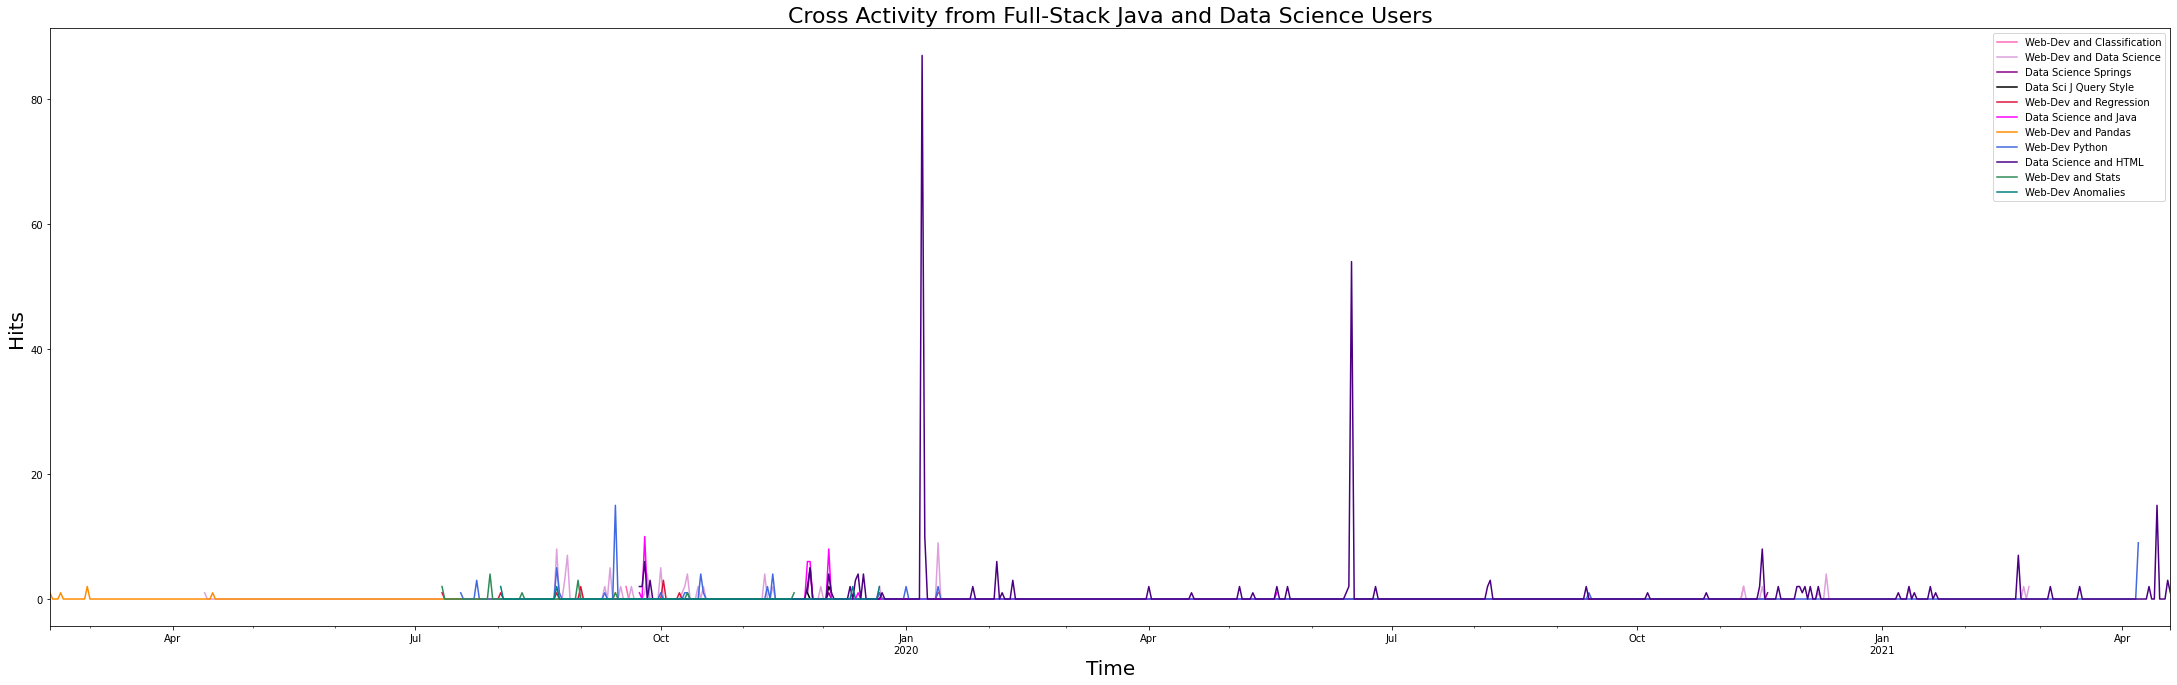

In [38]:
plt.figure(figsize = (38, 11))    # create figure for plots

plt.title('Cross Activity from Full-Stack Java and Data Science Users', size = 22)    # title

java_regression = cross_activity.path.resample('D').count()    # resample web dev users looking up regression

ds_java = cross_active.path.resample('D').count()    # resample data science users looking up java 

java_pandas = cross_activity2.path.resample('D').count()    # resample web dev users looking up pandas

java_python = cross_activity3.path.resample('D').count()    # resample web dev users looking up python

ds_html = cross_active2.path.resample('D').count()    # resample data science users looking up html

java_stats = cross_activity4.path.resample('D').count()    # resample web dev users looking up stats

jawa_anomaly = cross_activity5.path.resample('D').count()    # resample web dev users looking up anomaly material

cross_act6 = cross_activity6.path.resample('D').count()    # resample web dev and classification logs 

cross_act7 = cross_activity7.path.resample('D').count()    # resample web dev and classification logs

cross_act3 = cross_active3.path.resample('D').count()    # resample data science research into spring

cross_act4 = cross_active4.path.resample('D').count()    # resample data science research into jquery


cross_act6.plot(color = 'hotpink', label = 'Web-Dev and Classification')    # plot web dev and classification logs

cross_act7.plot(color = 'plum', label = 'Web-Dev and Data Science')     # plot web dev data science paths

cross_act3.plot(color = 'darkmagenta', label = 'Data Science Springs')    # plot data science research into spring

cross_act4.plot(color = 'black', label = 'Data Sci J Query Style')    # plot data science research into jquery

java_regression.plot(color = 'crimson', label = 'Web-Dev and Regression')   # plot web dev user activity in regards to regression

ds_java.plot(color = 'magenta', label =  'Data Science and Java')    # plot data science user activity in regards to java

java_pandas.plot(color = 'darkorange', label = 'Web-Dev and Pandas')    # plot web dev users looking up pandas

java_python.plot(color = 'royalblue', label = 'Web-Dev Python')    # plot we dev users looking up python

ds_html.plot(color = 'indigo', label = 'Data Science and HTML')    # plot data science users looking up html

java_stats.plot(color = 'seagreen', label = 'Web-Dev and Stats')    # plot web dev users researching stats

jawa_anomaly.plot(color = 'teal', label = 'Web-Dev Anomalies')    # plot web dev users looking up anomaly material

plt.legend()    # include legend

plt.ylabel('Hits', size = 20)    # label y-axis

plt.xlabel('Time', size = 20);    # label x-axis